## Predicting Visitor Purchases with BigQuery ML

[BigQuery ML](https://cloud.google.com/bigquery/docs/bigqueryml-analyst-start) (BigQuery machine learning) is a feature in BigQuery where data analysts can create, train, evaluate, and predict with machine learning models with minimal coding.

The Google Analytics Sample [Ecommerce dataset](https://www.blog.google/products/marketingplatform/analytics/introducing-google-analytics-sample) that has millions of Google Analytics records for the [Google Merchandise Store](https://shop.googlemerchandisestore.com/) loaded into BigQuery. In this lab, you will use this data to run some typical queries that businesses would want to know about their customers' purchasing habits.

### Objectives

- Use BigQuery to find public datasets
- Query and explore the ecommerce dataset
- Create a training and evaluation dataset to be used for batch prediction
- Create a classification (logistic regression) model in BigQuery ML
- Evaluate the performance of your machine learning model
- Predict and rank the probability that a visitor will make a purchase

### Open BigQuery Console

1. In the Google Cloud Console, select Navigation menu > BigQuery.

The Welcome to BigQuery in the Cloud Console message box opens. This message box provides a link to the quickstart guide and lists UI updates.

2. Click Done.


### Access the course dataset

Once BigQuery is open, open the [data-to-insights](https://console.cloud.google.com/bigquery?p=data-to-insights&d=ecommerce&t=web_analytics&page=table) project in a new browser tab to bring this project into your BigQuery projects panel.

The field definitions for the data-to-insights ecommerce dataset are on the [[UA] BigQuery Export schema page](https://support.google.com/analytics/answer/3437719?hl=en). Keep the link open in a new tab for reference.

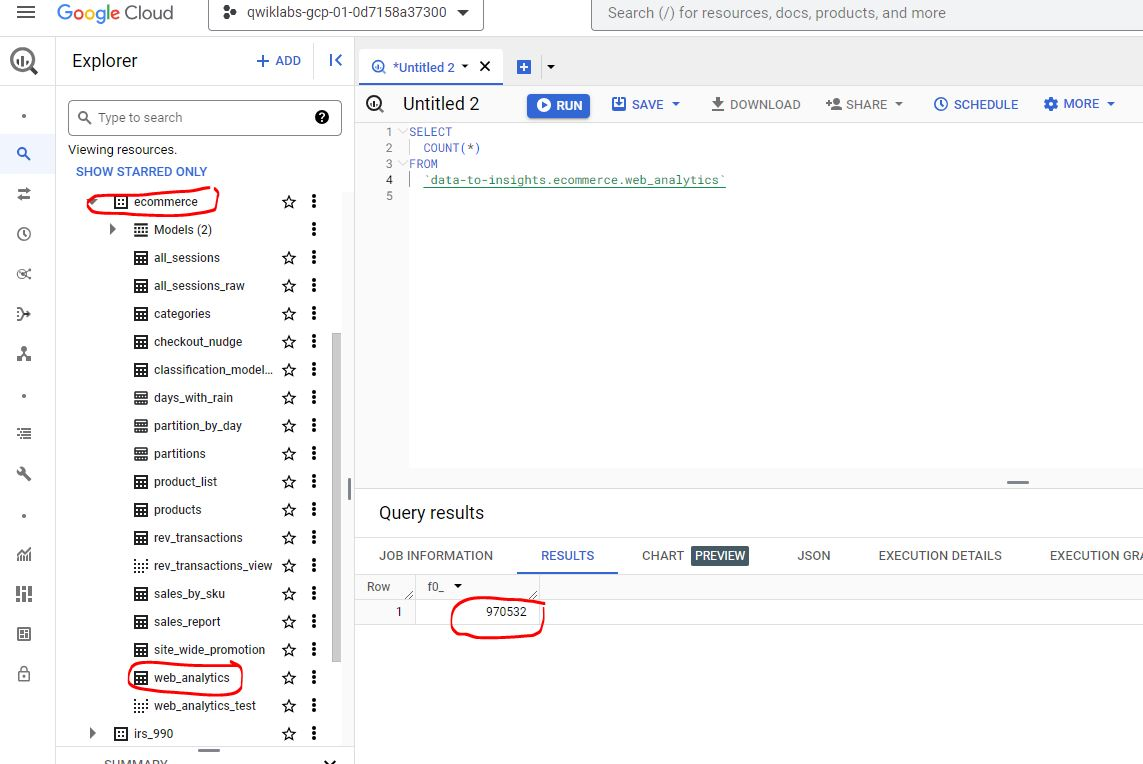

The `web_analytics` table has 970,532 rows.

### Task 1. Explore ecommerce data

`Scenario:` Your data analyst team exported the Google Analytics logs for an ecommerce website into BigQuery and created a new table of all the raw ecommerce visitor session data for you to explore. Using this data, you'll try to answer a few questions.

`Question 1:` Out of the total visitors who visited our website, what % made a purchase?

1. Click the query EDITOR.

2. Add the following to the New Query field:

In [ ]:
# Common Table Expression (CTE)
WITH visitors AS( # alias 'visitors'
SELECT
COUNT(DISTINCT fullVisitorId) AS total_visitors
FROM `data-to-insights.ecommerce.web_analytics`
),

# Common Table Expression (CTE)
purchasers AS( # alias 'purchasers'
SELECT
COUNT(DISTINCT fullVisitorId) AS total_purchasers
FROM `data-to-insights.ecommerce.web_analytics`
WHERE totals.transactions IS NOT NULL
)

SELECT
  total_visitors,
  total_purchasers,
  total_purchasers / total_visitors AS conversion_rate
FROM visitors, purchasers

3. Click Run.

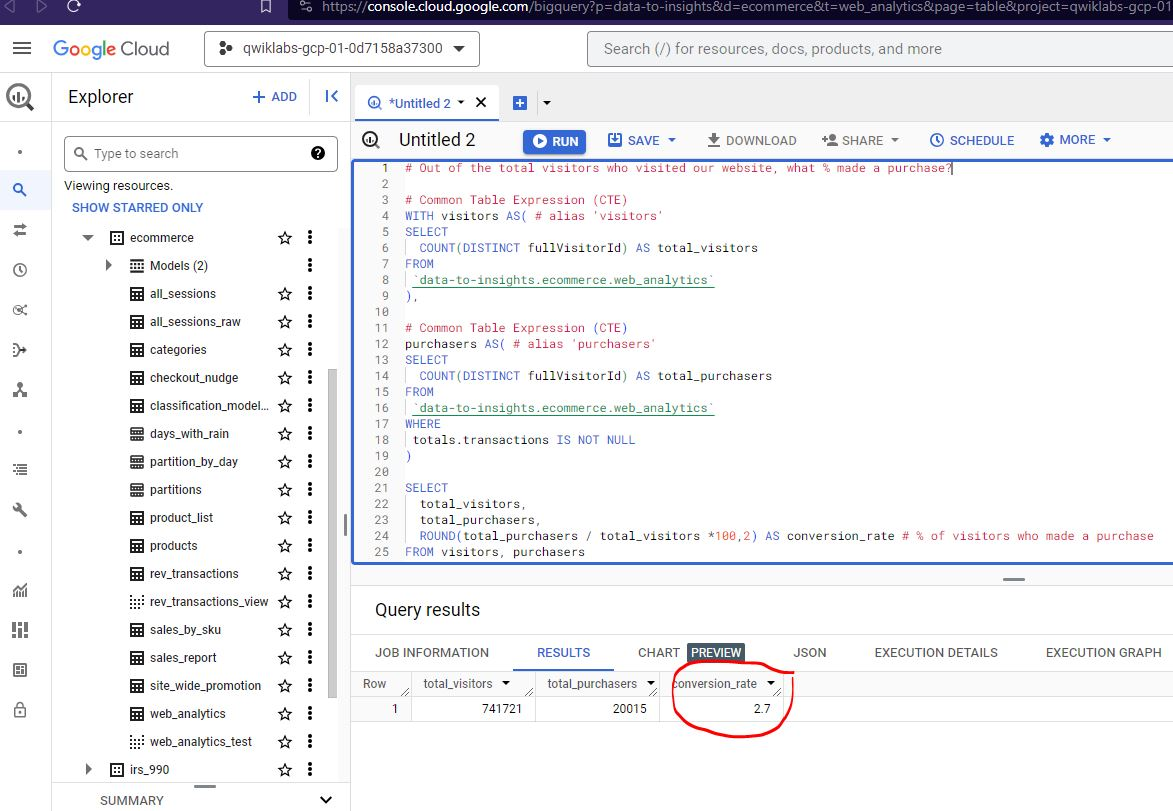

So, only 20,015 of the 741,721 total visitors who visited our website, made a purchase, which represents 2.7%.

`Question 2:` What are the top 5 selling products?

4. Add the following query in the query EDITOR, and then click Run:

In [ ]:
SELECT
  p.v2ProductName,
  p.v2ProductCategory,
  SUM(p.productQuantity) AS units_sold,
  ROUND(SUM(p.localProductRevenue/1000000),2) AS revenue
FROM `data-to-insights.ecommerce.web_analytics`,
UNNEST(hits) AS h,
UNNEST(h.product) AS p
GROUP BY 1, 2
ORDER BY revenue DESC
LIMIT 5;

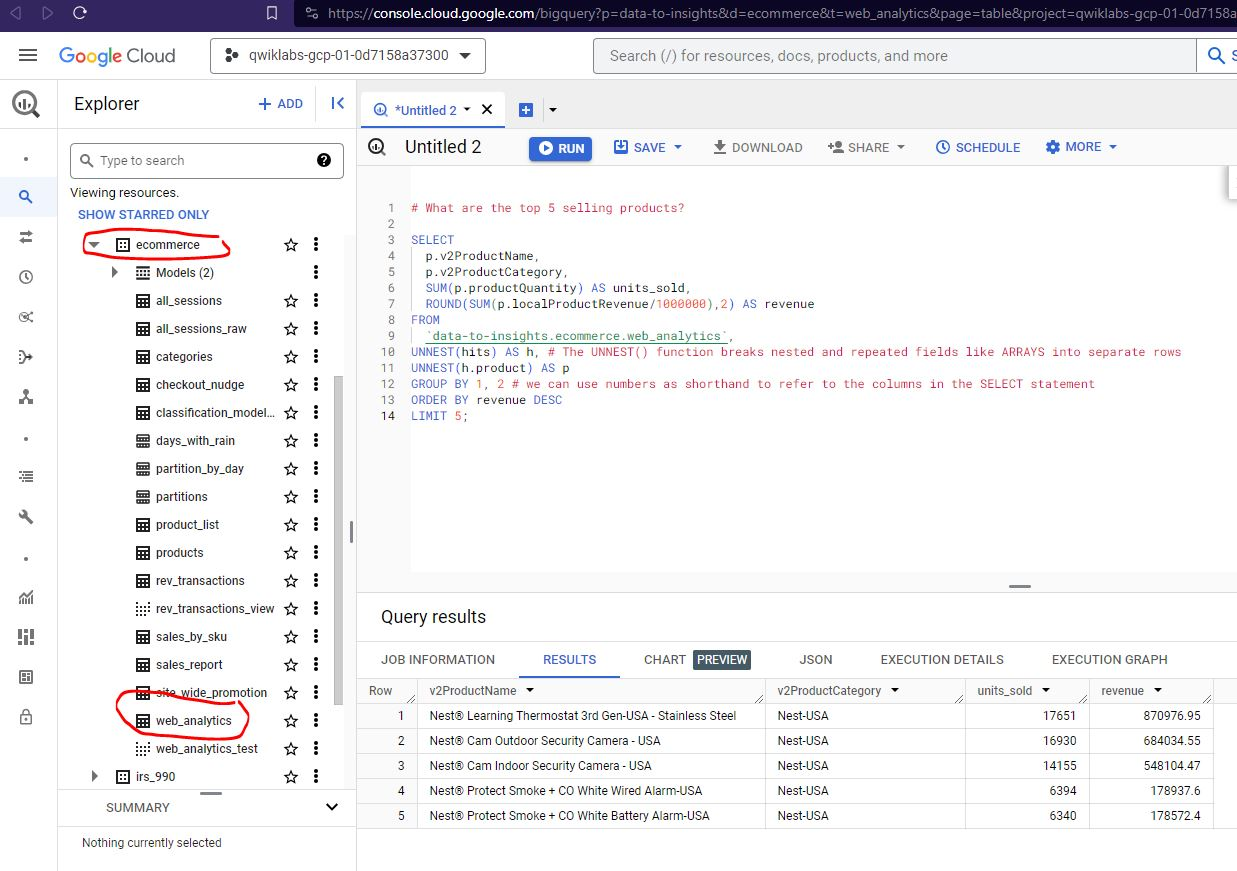

`Question 3:` How many visitors bought on subsequent visits to the website?

5. Run the following query to find out:

In [ ]:
# visitors who bought on a return visit (could have bought on first as well)
WITH all_visitor_stats AS (
SELECT
  fullvisitorid, # 741,721 unique visitors
  # if not first visit and customer makes purchase then populate with a value of 1, otherwise 0 - and then COUNT these. This will give # bought on subseq. visit  
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit # If this is 1st visit, totals.newVisits value is 1 otherwise NULL 
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)

SELECT
  COUNT(DISTINCT fullvisitorid) AS total_visitors,
  will_buy_on_return_visit
FROM all_visitor_stats
GROUP BY will_buy_on_return_visit

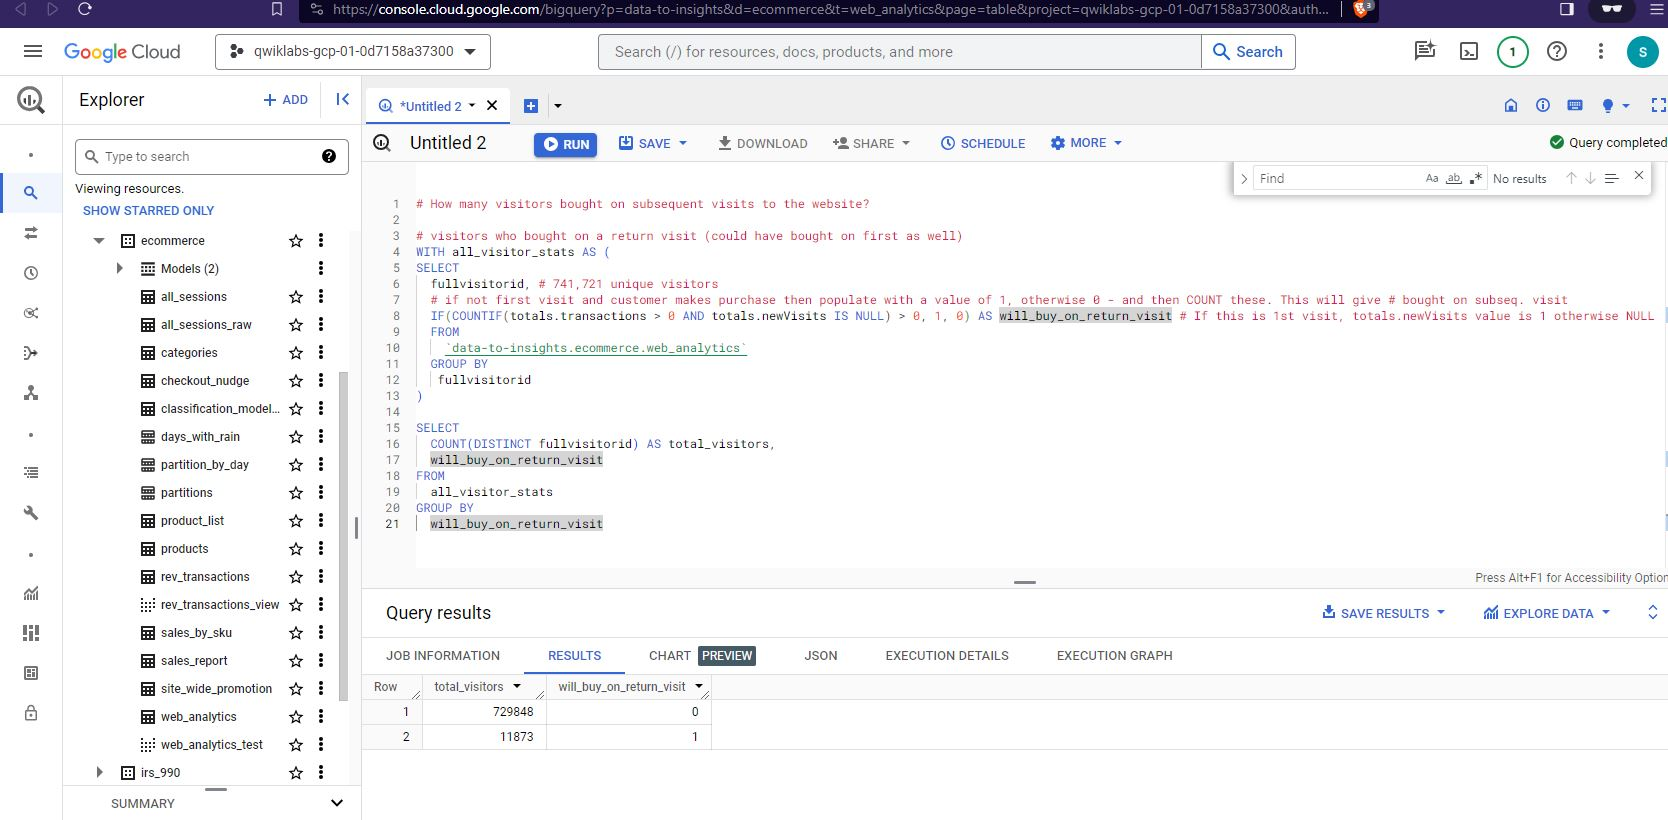

Analyzing the results, you can see that (11873 / 729848) = 1.6% of total visitors will return and purchase from the website. This includes the subset of visitors who bought on their very first session and then came back and bought again.

Some of the reasons a typical ecommerce customer will browse but not buy until a later visit are detailed below :

- The customer wants to comparison shop on other sites before making a purchase decision.
- The customer is waiting for products to go on sale or other promotion
- The customer is doing additional research

This behavior is very common for luxury goods where significant up-front research and comparison is required by the customer before deciding (think car purchases) but also true to a lesser extent for the merchandise on this site (t-shirts, accessories, etc).

In the world of online marketing, identifying and marketing to these future customers based on the characteristics of their first visit will increase conversion rates and reduce the outflow to competitor sites.

### Task 2. Select features and create your training dataset

Now you will create a Machine Learning model in BigQuery to predict whether or not a new user is likely to purchase in the future. Identifying these high-value users can help your marketing team target them with special promotions and ad campaigns.

Google Analytics captures a wide variety of dimensions and measures about a user's visit on this ecommerce website. Browse the complete list of fields in the [[UA] BigQuery Export schema Guide](https://support.google.com/analytics/answer/3437719?hl=en) and then [preview the demo dataset](https://bigquery.cloud.google.com/table/data-to-insights:ecommerce.web_analytics?tab=preview) to find useful features that will help a machine learning model understand the relationship between data about a visitor's first time on your website and whether they will return and make a purchase.

Your team decides to test whether these two fields are good inputs for your classification model:

- `totals.bounces` (whether the visitor left the website immediately)
- `totals.timeOnSite` (how long the visitor was on our website)

>Q. What are the risks of only using the above two fields?

- Whether a user bounces is highly correlated with their time on site (e.g. 0 seconds)
- Only using time spent on the site ignores other potential useful columns (features)
- Both of the above

Machine learning is only as good as the training data that is fed into it. If there isn't enough information for the model to determine and learn the relationship between your input features and your label (in this case, whether the visitor bought in the future) then you will not have an accurate model. While training a model on just these two fields is a start, you will see if they're good enough to produce an accurate model.

In the query EDITOR, add the following query and then click Run:


In [ ]:
SELECT
  * EXCEPT(fullVisitorId)
FROM

  # features
  (SELECT
    fullVisitorId,
    IFNULL(totals.bounces, 0) AS bounces, # returns 0 if the value of totals.bounces is NULL, otherwise returns the value
    IFNULL(totals.timeOnSite, 0) AS time_on_site  # returns 0 if the value of totals.timeOnSite is NULL, otherwise returns the value
  FROM
    `data-to-insights.ecommerce.web_analytics`
  WHERE
    totals.newVisits = 1) # first visit
  JOIN
  (SELECT
    fullvisitorid,
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit 
  FROM
      `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid)
  USING (fullVisitorId) # this is the common column we are joining on
ORDER BY time_on_site DESC
LIMIT 10;

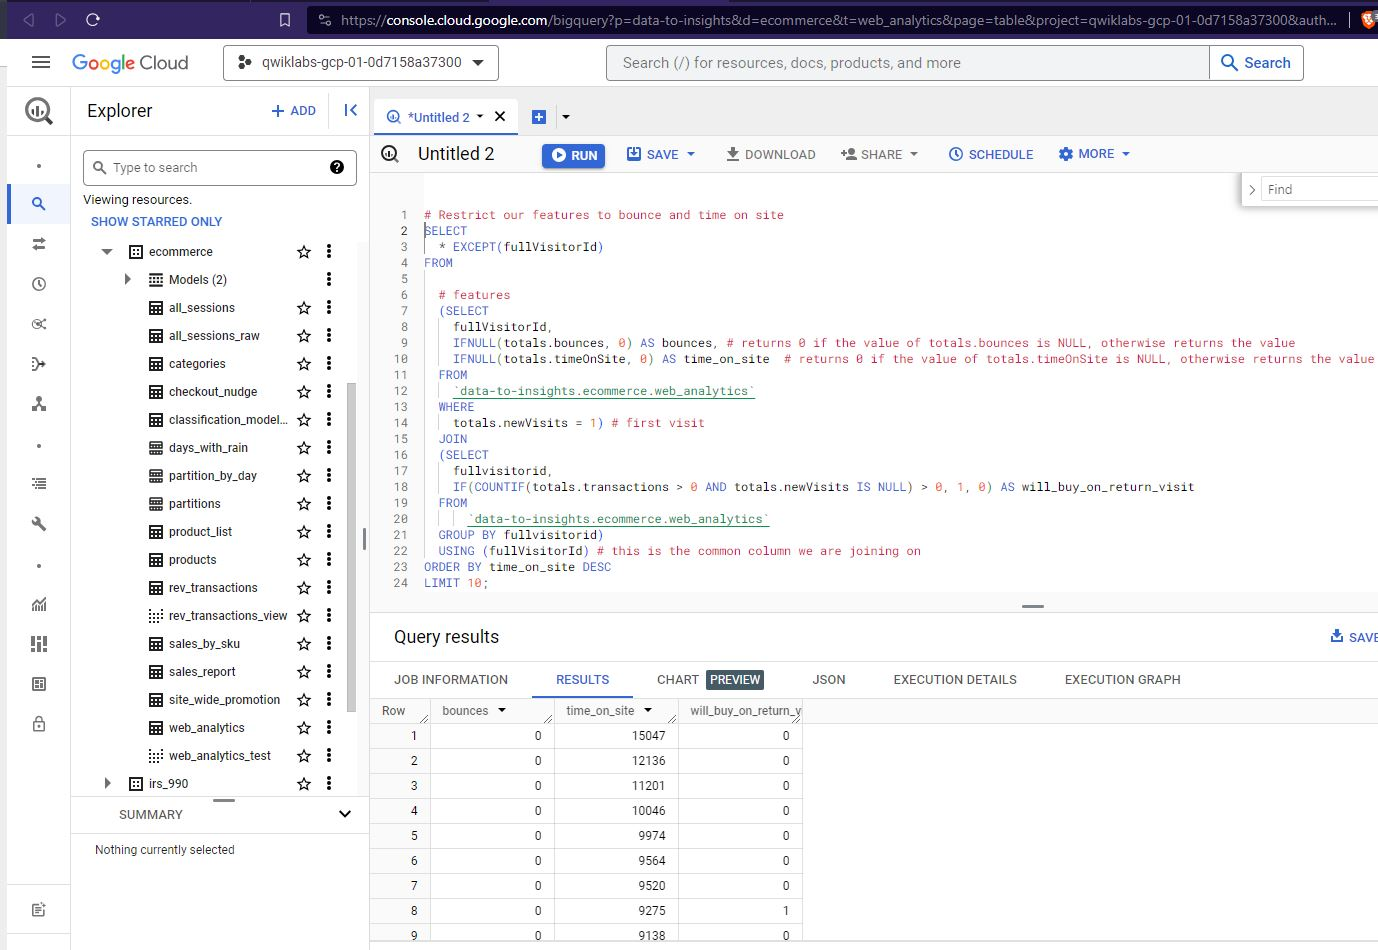

>Q1. Which fields are the model features? What is the label (correct answer)?

    - The features are bounces and will_buy_on_return_visit. The label is time_on_site
    - The feature is will_buy_on_return_visit. The labels are bounces and time_on_site
    
`The features are bounces and time_on_site. The label is will_buy_on_return_visit`

>Q2. Which fields are known after a visitor's first session? (Check all that apply)

    - will_buy_on_return_visit
`bounces`
`time_on_site`
`visitId`

>Q3. Which field isn't known until later in the future after their first session?

    - visitId
    
`will_buy_on_return_visit`

    - bounces
    - time_on_site

`Discussion:` `will_buy_on_return_visit` is not known after the first visit. Again, you're predicting for a subset of users who returned to your website and purchased. Since you don't know the future at prediction time, you cannot say with certainty whether a new visitor comes back and purchases. The value of building a ML model is to get the probability of future purchase based on the data gleaned about their first session.

`Question:` Looking at the initial data results, do you think `time_on_site` and `bounces` will be a good indicator of whether the user will return and purchase or not?

`Answer:` It's often too early to tell before training and evaluating the model, but at first glance out of the top 10 `time_on_site`, only 1 customer returned to buy, which isn't very promising. Let's see how well the model does.

### Task 3. Create a BigQuery dataset to store models

Next, create a new BigQuery dataset which will also store your ML models.

1. In the left pane, click on your project name, and then click on the View action icon (three dots) and select Create Dataset.

2. In the Create Dataset dialog:
- For Dataset ID, type ecommerce.
- Leave the other values at their defaults.

3. Click Create dataset.

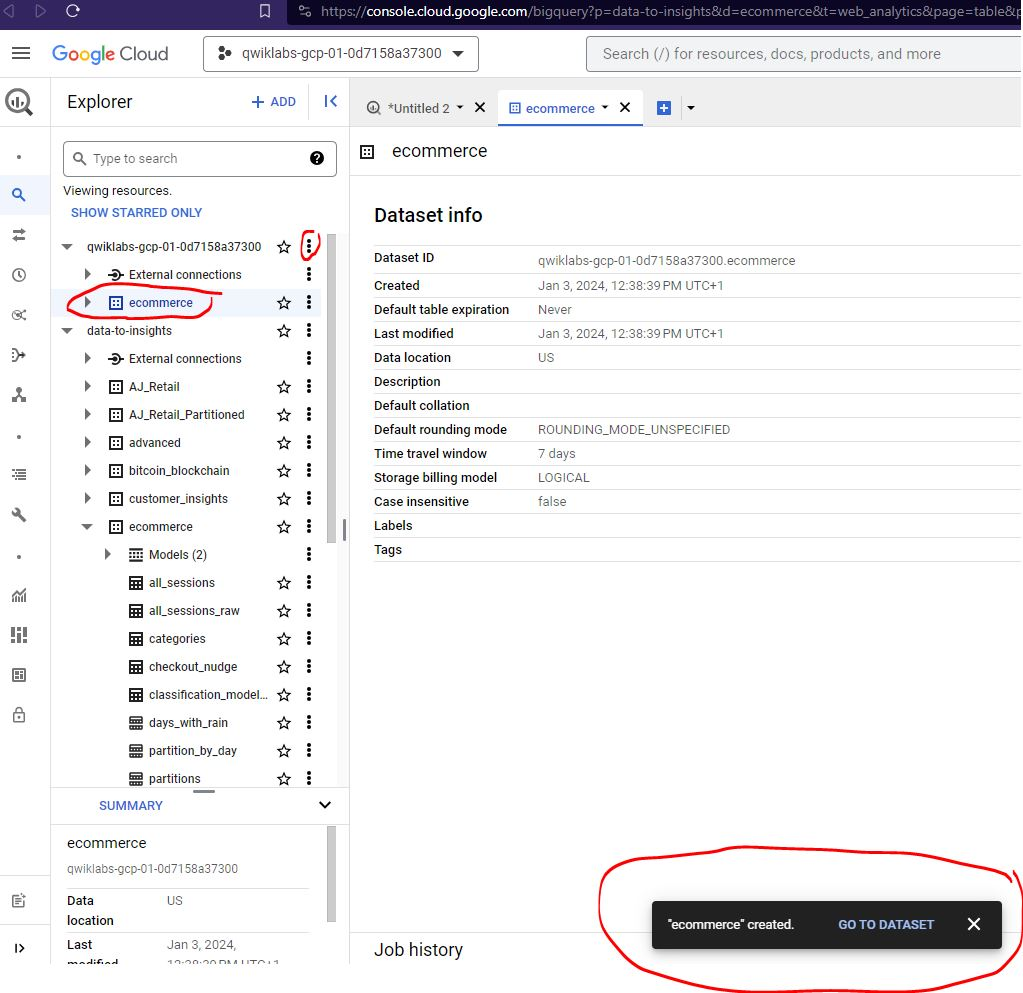

### Task 4. Select a BigQuery ML model type and specify options

Now that you have your initial features selected, you are now ready to create your first ML model in BigQuery.

There are the two model types to choose from:
    
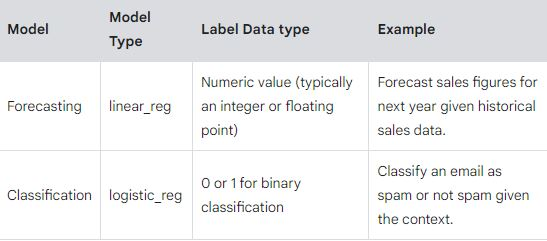

> Note: There are many additional model types used in Machine Learning (like Neural Networks and decision trees) and available using libraries like [TensorFlow](https://www.tensorflow.org/tutorials/). At the time of writing, BigQuery ML supports the two listed above.

>Q. Which model type should you choose that will buy or won't buy?

`Classification model (like logistic_reg etc.)`

    - Forecasting model (like linear_reg etc.)
    - Recommendation model (like matrix_factorization etc.)
    
1. Enter the following query to create a model and specify model options:

### Create a Logistic Regression - classification model - and train on 9 mths of data 1.8.16 to 30.4.17

In [ ]:
CREATE OR REPLACE MODEL `ecommerce.classification_model` # name the model
OPTIONS
(
model_type='logistic_reg',
labels = ['will_buy_on_return_visit']  # what we are trying to predict
)
AS

# The model will be created from the output of the following query
SELECT
  * EXCEPT(fullVisitorId)
FROM

  # features 
  (SELECT
    fullVisitorId,
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site
  FROM
    `data-to-insights.ecommerce.web_analytics`
  WHERE
    totals.newVisits = 1
    AND date BETWEEN '20160801' AND '20170430') # train on first 9 months
  JOIN
  (SELECT
    fullvisitorid,
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit # our label, i.e. whether customer bought on return visit
  FROM
      `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid)
  USING (fullVisitorId)
;

Wait for the model to train (5 - 10 minutes).

> Note: You cannot feed all of your available data to the model during training since you need to save some unseen data points for model evaluation and testing. To accomplish this, add a WHERE clause condition is being used to filter and train on only the first 9 months of session data in your 12 month dataset.

After your model is trained, you will see the message "This statement created a new model named qwiklabs-gcp-xxxxxxxxx:ecommerce.classification_model".

3. Click Go to model.
Look inside the ecommerce dataset and confirm `classification_model` now appears.

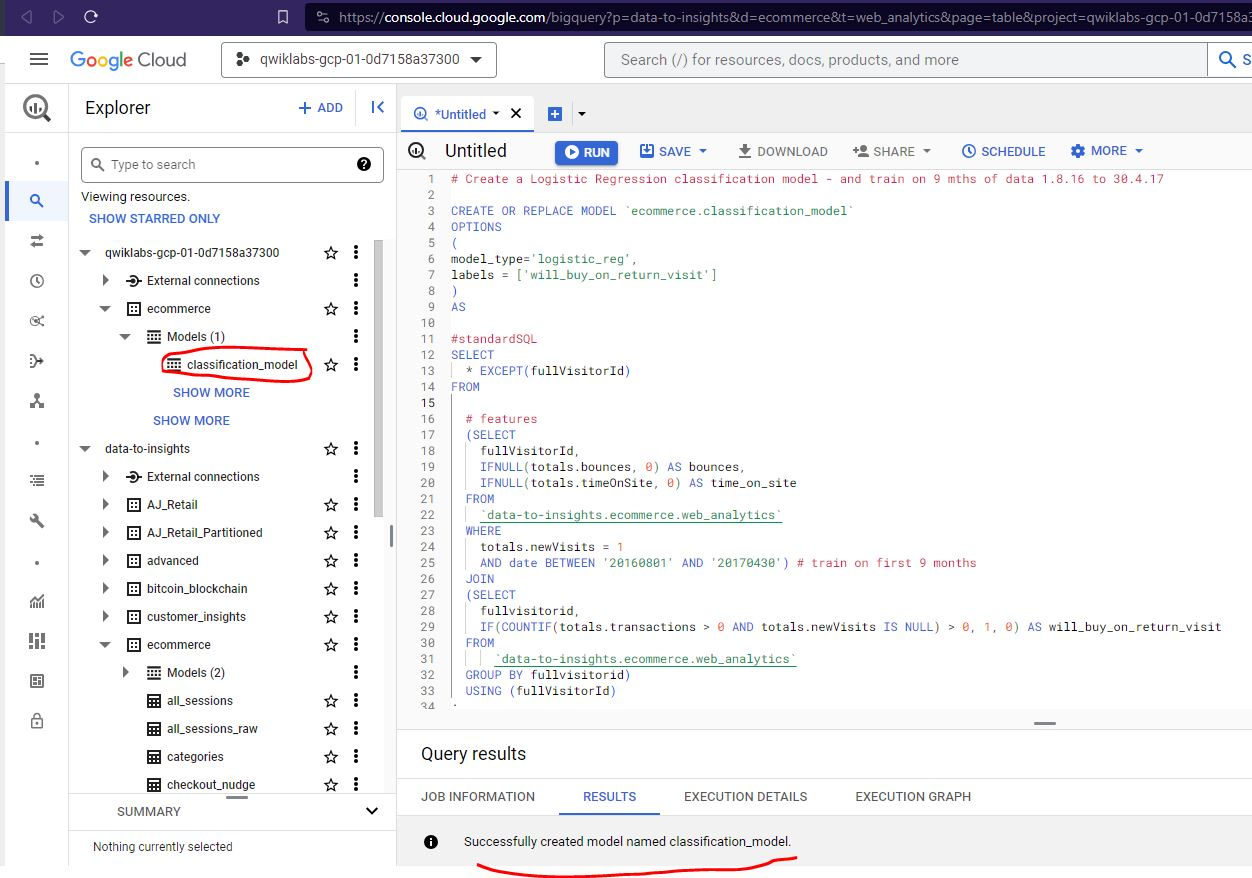

Next, you will evaluate the performance of the model against new unseen evaluation data.

### Task 5. Evaluate classification model performance

`Select your performance criteria`:
    
For classification problems in ML, you want to minimize the False Positive Rate (predict that the user will return and purchase and they don't) and maximize the True Positive Rate (predict that the user will return and purchase and they do).

This relationship is visualized with a ROC (Receiver Operating Characteristic) curve like the one shown here, where you try to maximize the area under the curve or AUC:

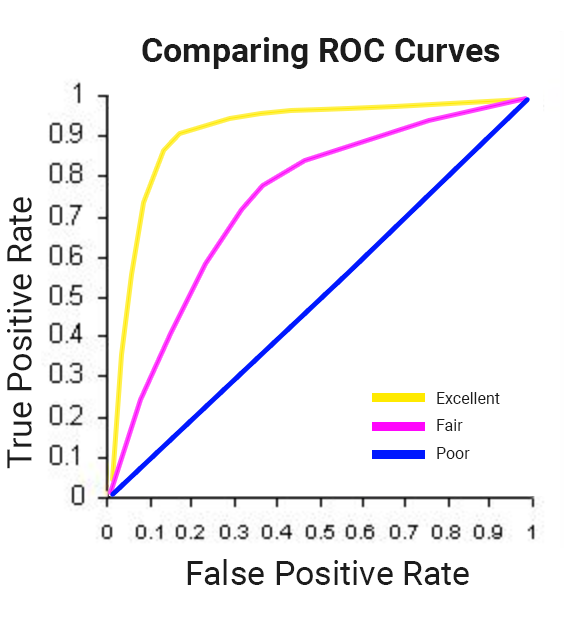

In BigQuery ML, `roc_auc` is simply a queryable field when evaluating your trained ML model.

Now that training is complete, you can evaluate how well the model performs by running this query using `ML.EVALUATE`

### Evaluate the Logistic Regression - classification model on unseen data 1.5.17 to 30.6.17

In [ ]:
SELECT
  roc_auc,
  CASE
    WHEN roc_auc > .9 THEN 'good'
    WHEN roc_auc > .8 THEN 'fair'
    WHEN roc_auc > .7 THEN 'not great'
  ELSE 'poor' END AS model_quality
FROM
  ML.EVALUATE(MODEL ecommerce.classification_model,  (

SELECT
  * EXCEPT(fullVisitorId)
FROM

  # features
  (SELECT
    fullVisitorId,
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site
  FROM
    `data-to-insights.ecommerce.web_analytics`
  WHERE
    totals.newVisits = 1
    AND date BETWEEN '20170501' AND '20170630') # eval on 2 months
  JOIN
  (SELECT
    fullvisitorid,
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM
      `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid)
  USING (fullVisitorId)

));

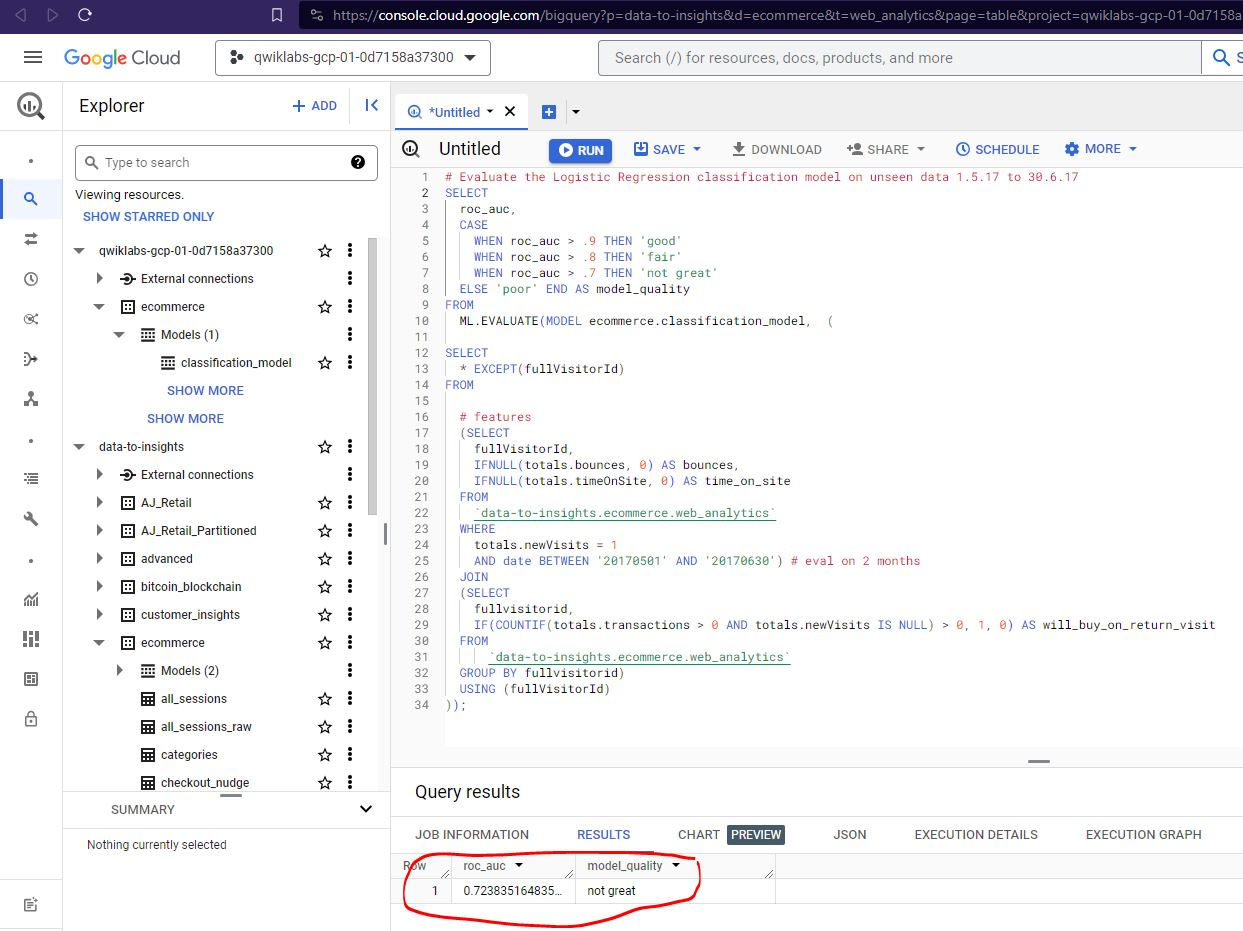

After evaluating your model you get a `roc_auc` of 0.72, which shows that the model has not great predictive power. Since the goal is to get the area under the curve as close to 1.0 as possible, there is room for improvement.

### Task 6. Improve model performance with feature engineering

As was hinted at earlier, there are many more features in the dataset that may help the model better understand the relationship between a visitor's first session and the likelihood that they will purchase on a subsequent visit.

Add some new features and create a second machine learning model called `classification_model_2`:

- How far the visitor got in the checkout process on their first visit
- Where the visitor came from (traffic source: organic search, referring site etc.)
- Device category (mobile, tablet, desktop)
- Geographic information (country)

Create this second model by running the below query:

### Feature engineer our Logistic Regression - classification model

In [ ]:
CREATE OR REPLACE MODEL `ecommerce.classification_model_2`
OPTIONS
  (model_type='logistic_reg', labels = ['will_buy_on_return_visit']) AS

WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)

# add in new features
SELECT * EXCEPT(unique_session_id) FROM (

  SELECT
      CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,

      # labels
      will_buy_on_return_visit,

     # 1, Product detail views = 2, Add product(s) to cart = 3, Remove product(s) from cart = 4
     # Check out = 5, Completed purchase = 6, Refund of purchase = 7, Checkout options = 8, Unknown = 0
    
      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress, # how far visitor got in checkout process on 1st visit

      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,

      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,

      # mobile or desktop
      device.deviceCategory,

      # geographic
      IFNULL(geoNetwork.country, "") AS country # if NUll populate with a blank

  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h # use UNNEST function on hits to create an intermediary table ALIAS h

    JOIN all_visitor_stats USING(fullvisitorid)

  WHERE 1=1
    # only predict for new visits
    AND totals.newVisits = 1
    AND date BETWEEN '20160801' AND '20170430' # train 9 months

  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
);

> Note: You are still training on the same first 9 months of data, even with this new model. It's important to have the same training dataset so you can be certain a better model output is attributable to better input features and not new or different training data

A key new feature that was added to the training dataset query is the maximum checkout progress each visitor reached in their session, which is recorded in the field `hits.eCommerceAction.action_type`. If you search for that field in the [field definitions](https://support.google.com/analytics/answer/3437719?hl=en) you will see the field mapping of 6 = Completed Purchase.

As an aside, the web analytics dataset has nested and repeated fields like ARRAYS which need to be broken apart into separate rows in your dataset. This is accomplished by using the `UNNEST()` function, which you can see in the above query.

Wait for the new model to finish training (5-10 minutes).

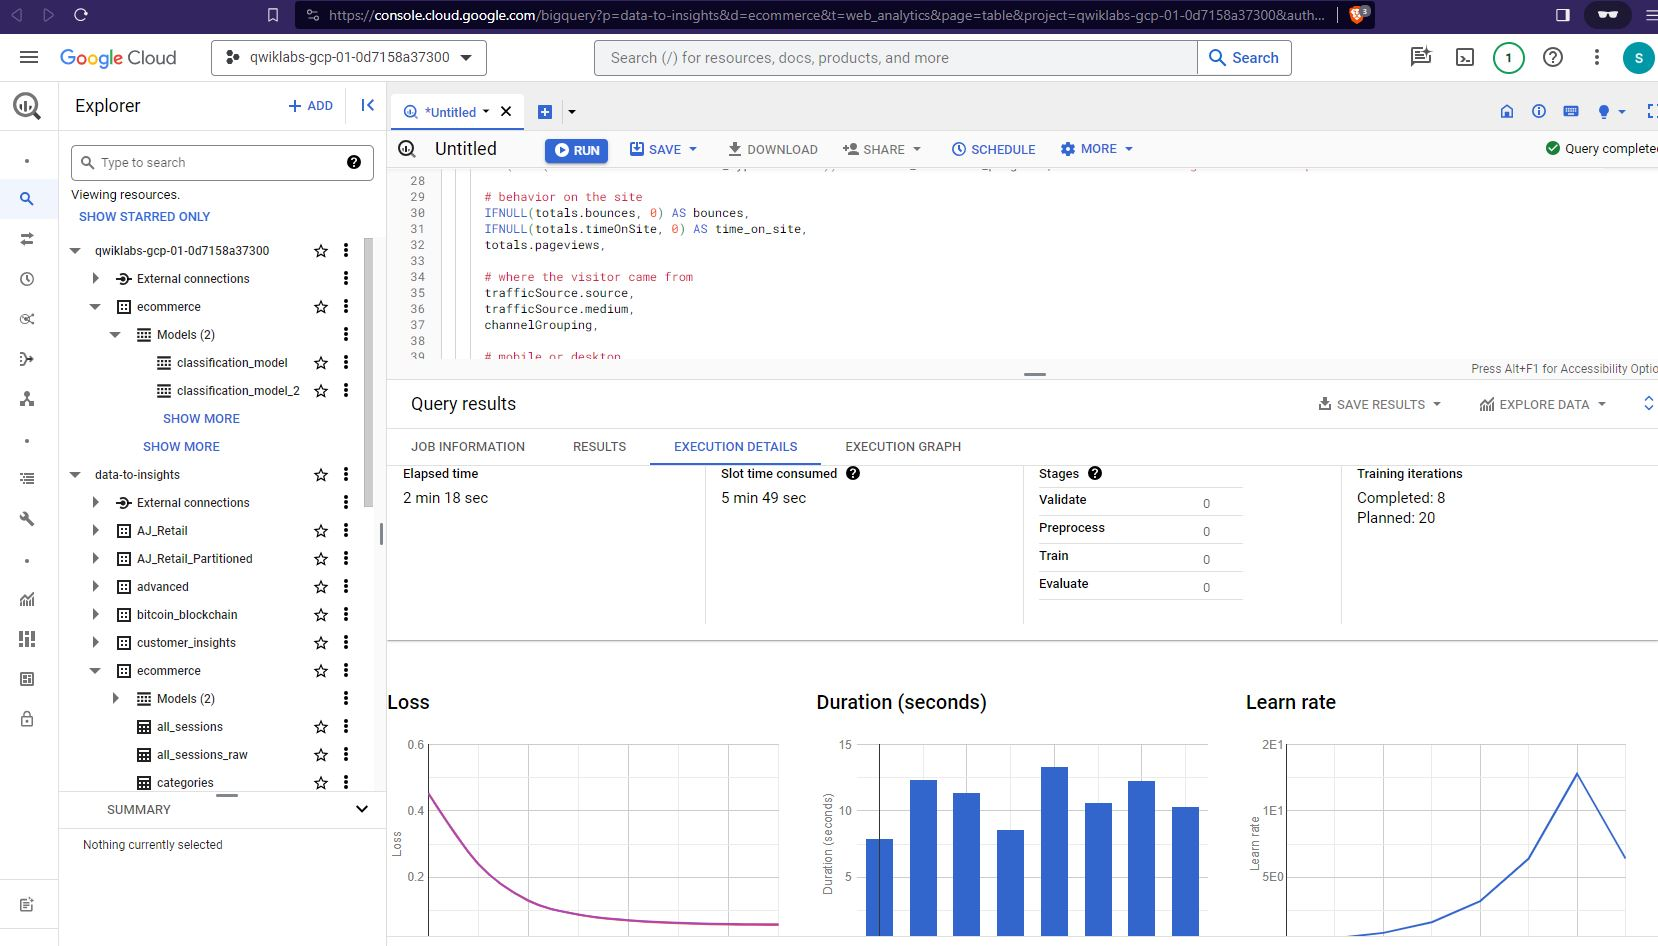

### Evaluate the newly feature engineered Logistic Regression - classification model

Evaluate this new model to see if there is better predictive power by running the below query:

In [ ]:
#standardSQL
SELECT
  roc_auc,
  CASE
    WHEN roc_auc > .9 THEN 'good'
    WHEN roc_auc > .8 THEN 'fair'
    WHEN roc_auc > .7 THEN 'not great'
  ELSE 'poor' END AS model_quality
FROM
  ML.EVALUATE(MODEL ecommerce.classification_model_2,  (

WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)

# add in new features
SELECT * EXCEPT(unique_session_id) FROM (

  SELECT
      CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,

      # labels
      will_buy_on_return_visit,

      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,

      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,

      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,

      # mobile or desktop
      device.deviceCategory,

      # geographic
      IFNULL(geoNetwork.country, "") AS country

  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h

    JOIN all_visitor_stats USING(fullvisitorid)

  WHERE 1=1 # allows for a consistent and easy-to-manage structure when building complex queries dynamically
    # only predict for new visits
    AND totals.newVisits = 1
    AND date BETWEEN '20170501' AND '20170630' # eval 2 months

  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
)
));

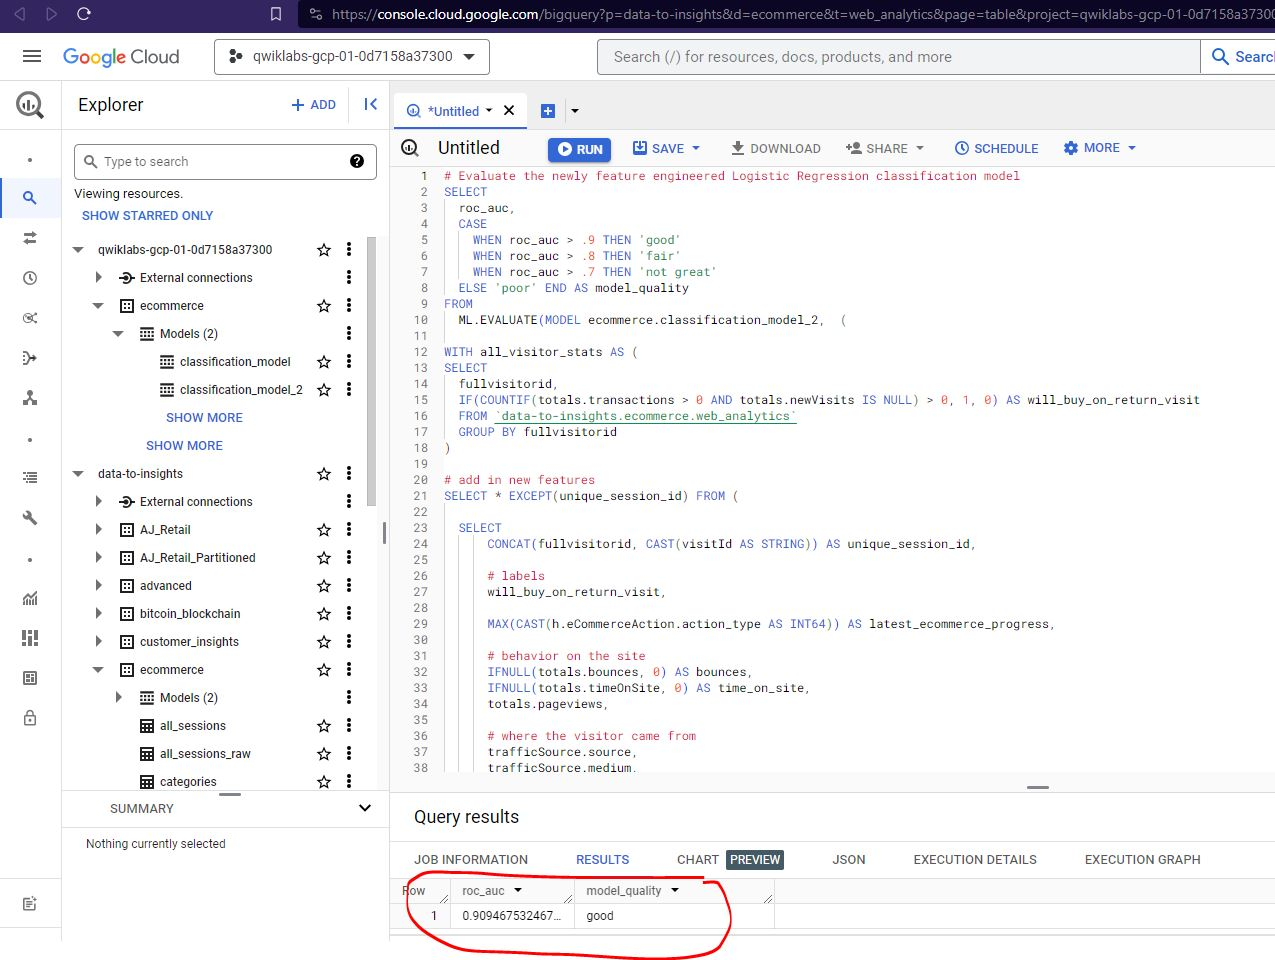


With this new model you now get a `roc_auc` of 0.91 which is significantly better than the first model.

Now that you have a trained model, time to make some predictions.

### Task 7. Predict which new visitors will come back and purchase

Next you will write a query to predict which new visitors will come back and make a purchase.

Run the prediction query below which uses the improved classification model to predict the probability that a first-time visitor to the Google Merchandise Store will make a purchase in a later visit:

### Make predictions on unseen data - 01.07.17 to 01.08.17

In [ ]:
SELECT
*
FROM
  ml.PREDICT(MODEL `ecommerce.classification_model_2`,
   (

WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)

  SELECT
      CONCAT(fullvisitorid, '-',CAST(visitId AS STRING)) AS unique_session_id,

      # labels
      will_buy_on_return_visit,

      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,

      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,

      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,

      # mobile or desktop
      device.deviceCategory,

      # geographic
      IFNULL(geoNetwork.country, "") AS country

  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h

    JOIN all_visitor_stats USING(fullvisitorid)

  WHERE
    # only predict for new visits
    totals.newVisits = 1
    AND date BETWEEN '20170701' AND '20170801' # test 1 month

  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
)

)

ORDER BY
  predicted_will_buy_on_return_visit DESC; # note we are ordering on a column which we didn't SELECT. Rather this is generated by the model

The predictions are made in the last 1 month (out of 12 months) of the dataset.

Your model will now output the predictions it has for those July 2017 ecommerce sessions. You can see three newly added fields:

- `predicted_will_buy_on_return_visit:` whether the model thinks the visitor will buy later (1 = yes)
- `predicted_will_buy_on_return_visit_probs.label:` the binary classifier for yes / no
- `predicted_will_buy_on_return_visit_probs.prob:` the confidence the model has in it's prediction (1 = 100%)

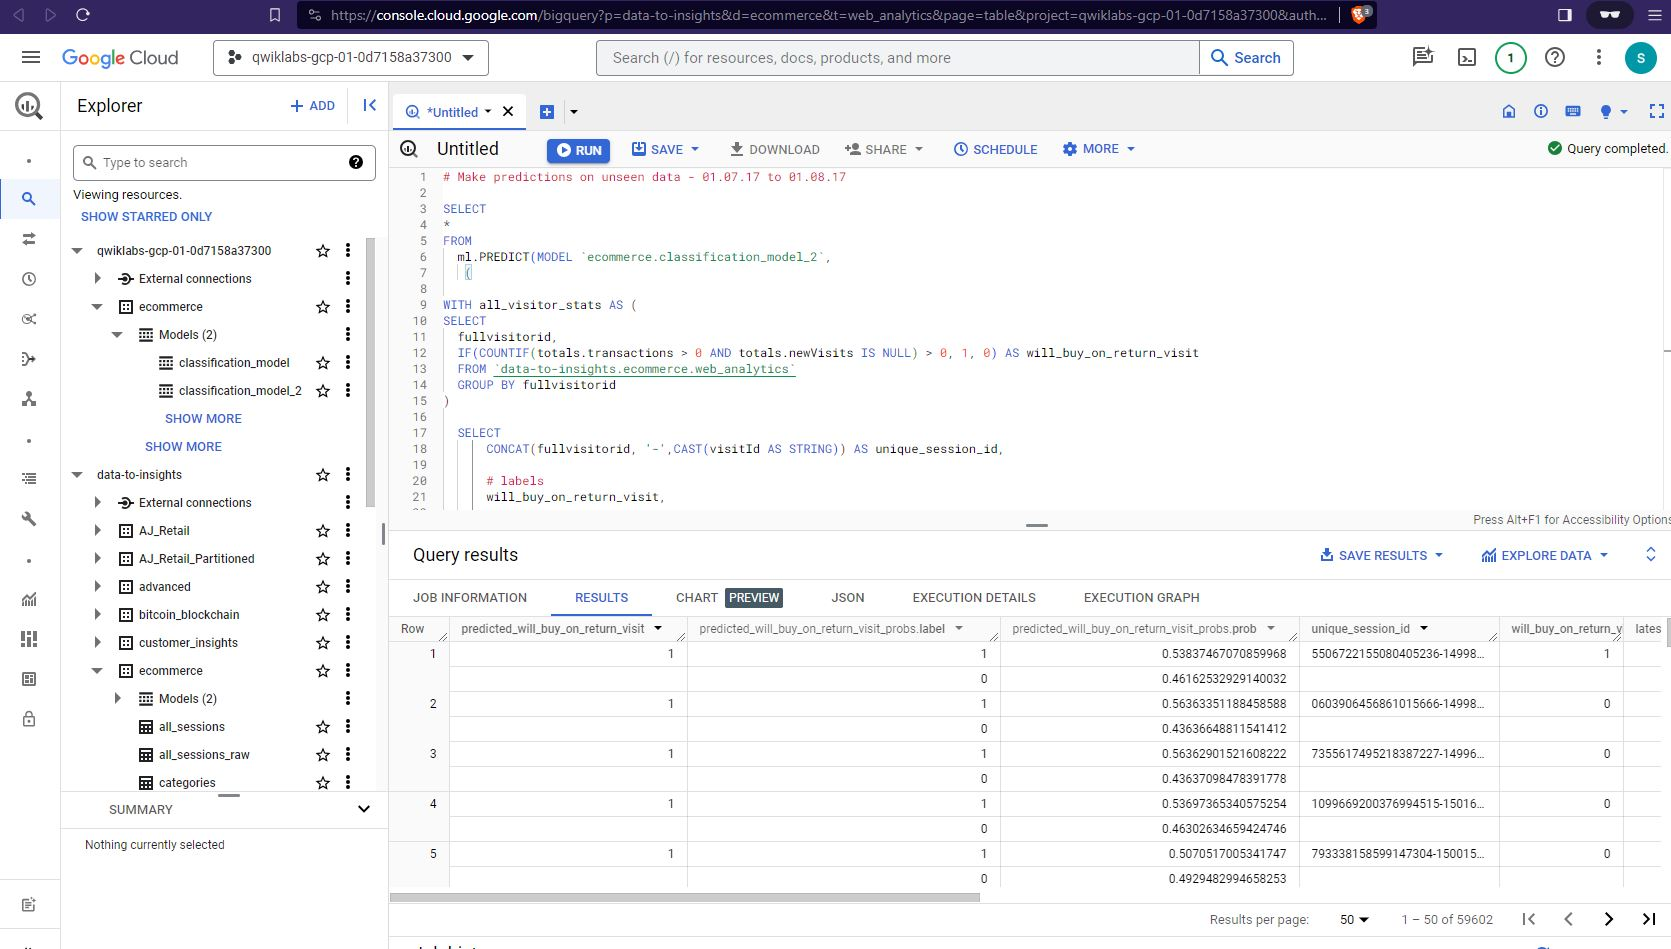

### Results
- Of the top 6% of first-time visitors (sorted in decreasing order of predicted probability), more than 6% make a purchase in a later visit.
- These users represent nearly 50% of all first-time visitors who make a purchase in a later visit.
- Overall, only 0.7% of first-time visitors make a purchase in a later visit.
- Targeting the top 6% of first-time increases marketing ROI by 9x vs targeting them all!


### Additional information
`roc_auc` is just one of the performance metrics available during model evaluation. Also available are [accuracy, precision, and recall](https://en.wikipedia.org/wiki/Precision_and_recall). Knowing which performance metric to rely on is highly dependent on what your overall objective or goal is.

### Challenge

In the previous two tasks you saw the power of feature engineering at work in improving our models performance. However, we still may be able to improve our performance by exploring other model types. For classification problems, BigQuery ML also supports the following model types:

- [Deep Neural Networks](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-dnn-models)
- [Boosted Decision Trees (XGBoost)](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree)
- [AutoML Tables Models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-automl)
- [Importing Custom TensorFlow Models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-tensorflow)

Though our linear classification (logistic regression) model performed well after feature engineering, it may be too simple of a model to fully capture the relationship between the features and the label. 

> Using the same dataset and labels as you did in Task 6 to create the model `ecommerce.classification_model_2`, your challenge is to create a XGBoost Classifier.

You may need to look at the documentation linked above to see the exact syntax. The model will take around 7 minutes to train. 

### Boosted Tree Classifer

In [ ]:
CREATE OR REPLACE MODEL `ecommerce.classification_model_3`
        OPTIONS
          (model_type='BOOSTED_TREE_CLASSIFIER' , l2_reg = 0.1, num_parallel_tree = 8, max_tree_depth = 10, # this is the only line of code that changes
              labels = ['will_buy_on_return_visit']) AS

        WITH all_visitor_stats AS (
        SELECT
          fullvisitorid,
          IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
          FROM `data-to-insights.ecommerce.web_analytics`
          GROUP BY fullvisitorid
        )

        # add in new features
        SELECT * EXCEPT(unique_session_id) FROM (

          SELECT
              CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,

              # labels
              will_buy_on_return_visit,

              MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,

              # behavior on the site
              IFNULL(totals.bounces, 0) AS bounces,
              IFNULL(totals.timeOnSite, 0) AS time_on_site,
              totals.pageviews,

              # where the visitor came from
              trafficSource.source,
              trafficSource.medium,
              channelGrouping,

              # mobile or desktop
              device.deviceCategory,

              # geographic
              IFNULL(geoNetwork.country, "") AS country

          FROM `data-to-insights.ecommerce.web_analytics`,
             UNNEST(hits) AS h

            JOIN all_visitor_stats USING(fullvisitorid)

          WHERE 1=1
            # only predict for new visits
            AND totals.newVisits = 1
            AND date BETWEEN '20160801' AND '20170430' # train 9 months

          GROUP BY
          unique_session_id,
          will_buy_on_return_visit,
          bounces,
          time_on_site,
          totals.pageviews,
          trafficSource.source,
          trafficSource.medium,
          channelGrouping,
          device.deviceCategory,
          country
        );

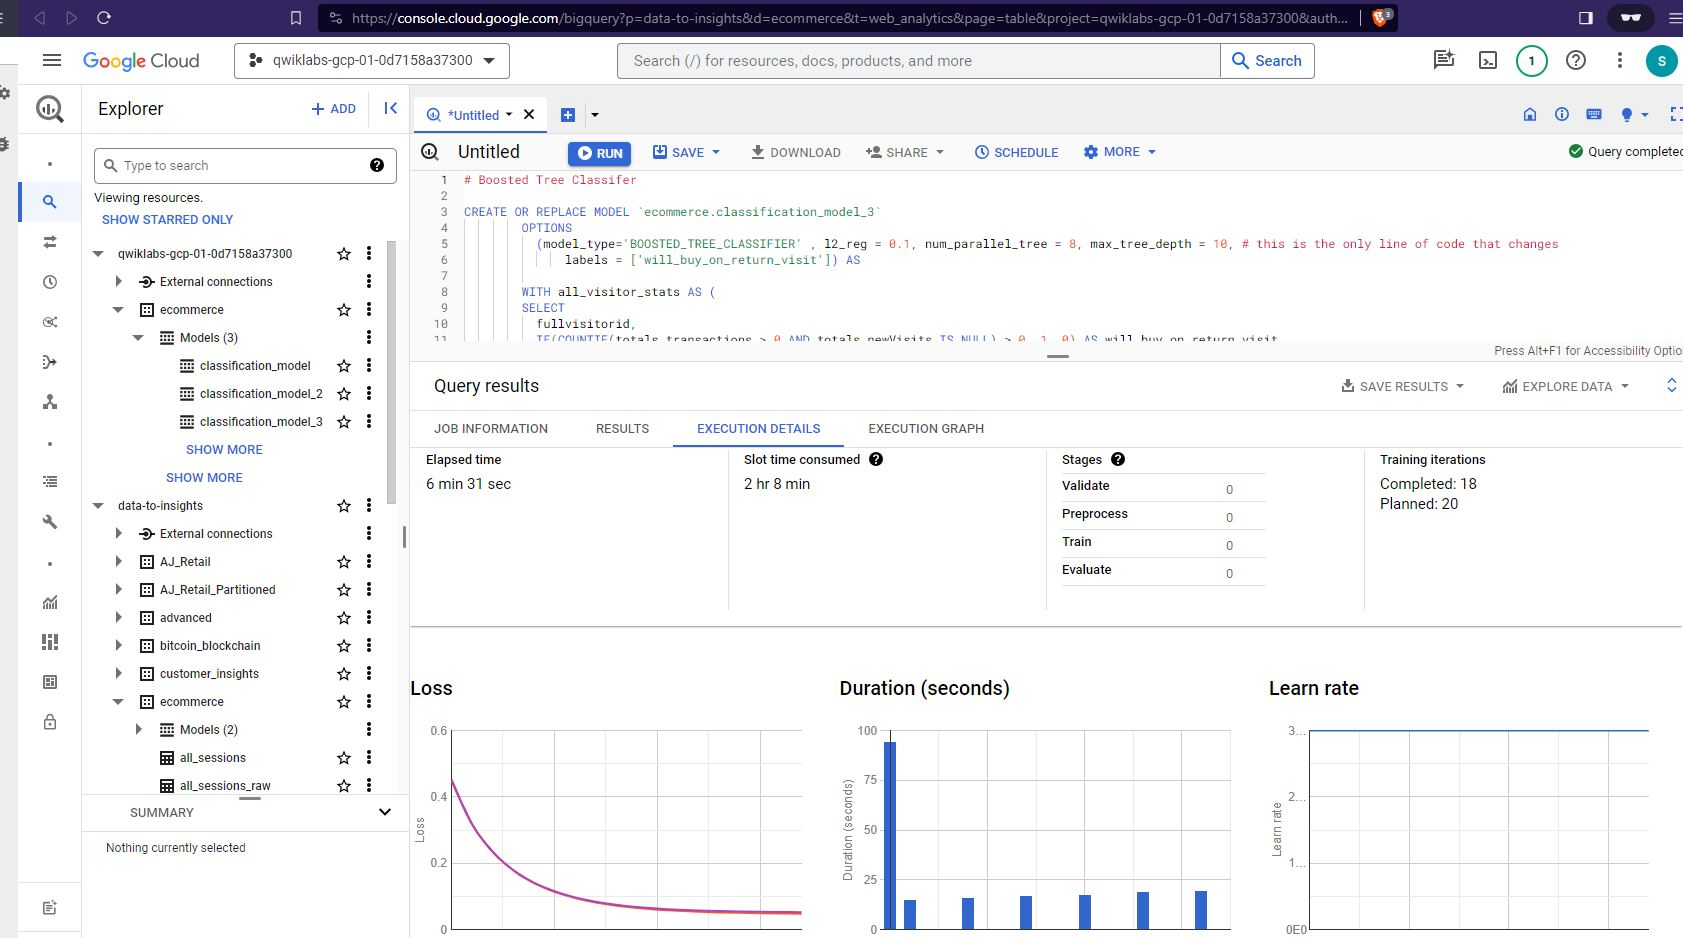

### Evaluation - Boosted Tree Classifier

Let us now evaluate our model and see how we did:

In [ ]:
#standardSQL
SELECT
  roc_auc,
  CASE
    WHEN roc_auc > .9 THEN 'good'
    WHEN roc_auc > .8 THEN 'fair'
    WHEN roc_auc > .7 THEN 'not great'
  ELSE 'poor' END AS model_quality
FROM
  ML.EVALUATE(MODEL ecommerce.classification_model_3,  (

WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)

# add in new features
SELECT * EXCEPT(unique_session_id) FROM (

  SELECT
      CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,

      # labels
      will_buy_on_return_visit,

      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,

      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,

      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,

      # mobile or desktop
      device.deviceCategory,

      # geographic
      IFNULL(geoNetwork.country, "") AS country

  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h

    JOIN all_visitor_stats USING(fullvisitorid)

  WHERE 1=1
    # only predict for new visits
    AND totals.newVisits = 1
    AND date BETWEEN '20170501' AND '20170630' # eval 2 months

  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
)
));

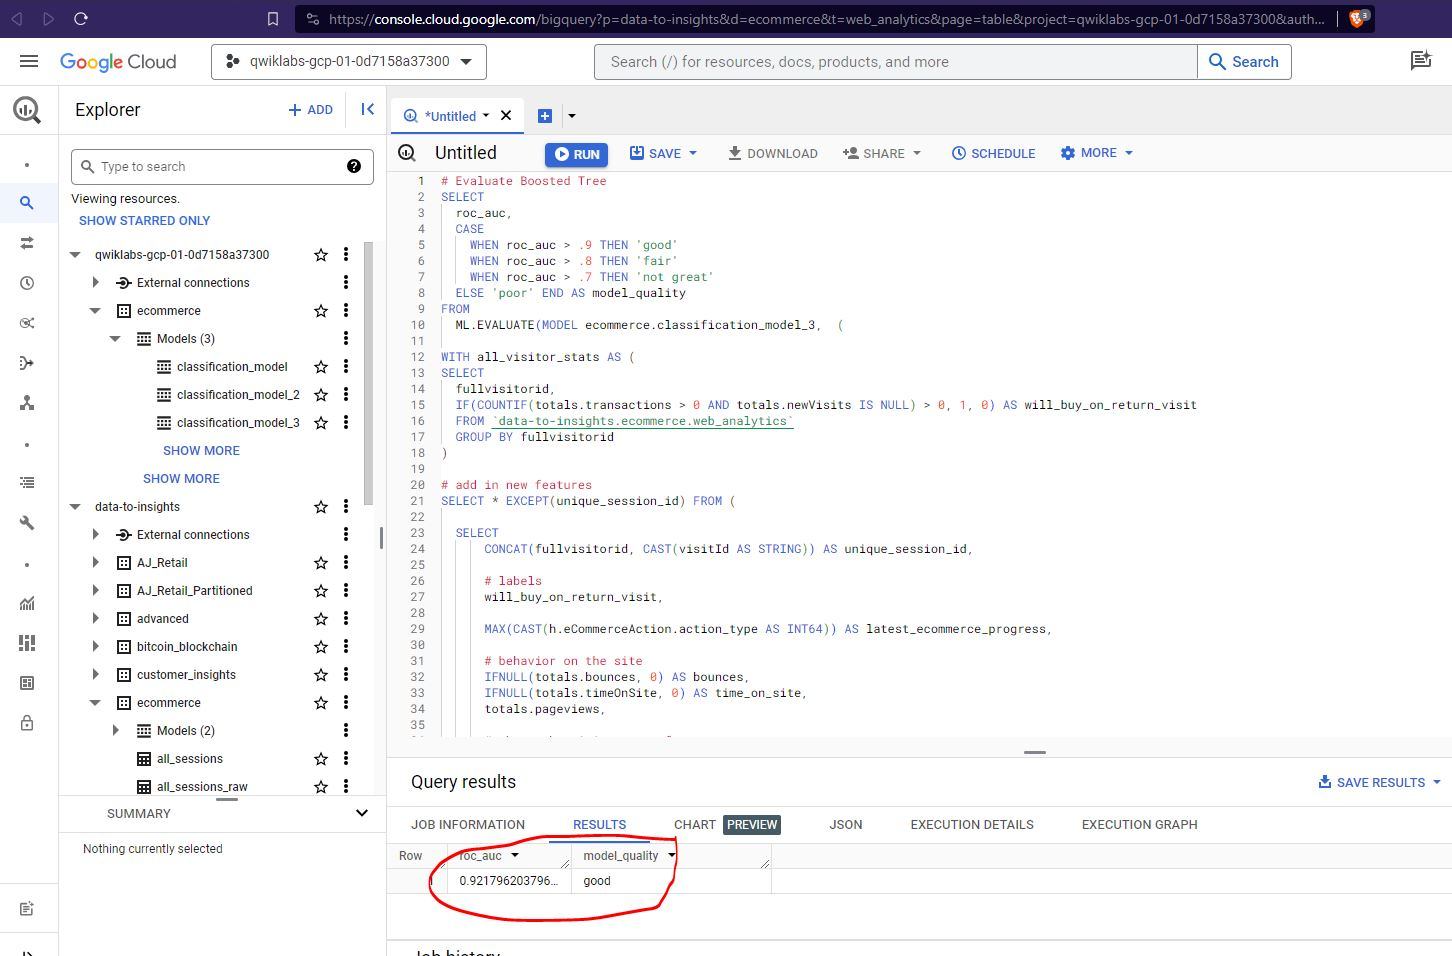

Our `roc_auc` has increased by about 0.01 to around 0.92!

> Note : Your exact values will differ due to the randomness involved in the training process.

It’s a small change in the roc_auc, but note that since 1.0 is a perfect `roc_auc`, it gets more difficult to improve the metric the closer to 1.0 it gets.

This is a great example of how easy it is in BigQuery ML to try out different model types with different options to see how they perform. We were able to use a much more complex model type by only `changing one line of SQL`.

One may reasonably ask “Where did the choices for these options come from?”, and the answer is experimentation! When you are trying to find the best model type for your problems, then one has to experiment with different sets of options in a process known as hyperparameter tuning.

Let’s finish up by generating predictions with our improved model and see how they compare to those we generated before. By using a Boosted tree classifier model, you can observe a slight improvement of 0.2 in our ROC AUC compared to the previous model. The query below will predict which new visitors will come back and make a purchase:

### Boosted Tree Classifier - Predictions

In [ ]:
SELECT
*
FROM
  ml.PREDICT(MODEL `ecommerce.classification_model_3`,
   (

WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)

  SELECT
      CONCAT(fullvisitorid, '-',CAST(visitId AS STRING)) AS unique_session_id,

      # labels
      will_buy_on_return_visit,

      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,

      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,

      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,

      # mobile or desktop
      device.deviceCategory,

      # geographic
      IFNULL(geoNetwork.country, "") AS country

  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h

    JOIN all_visitor_stats USING(fullvisitorid)

  WHERE
    # only predict for new visits
    totals.newVisits = 1
    AND date BETWEEN '20170701' AND '20170801' # test 1 month

  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
)

)

ORDER BY
  predicted_will_buy_on_return_visit DESC;

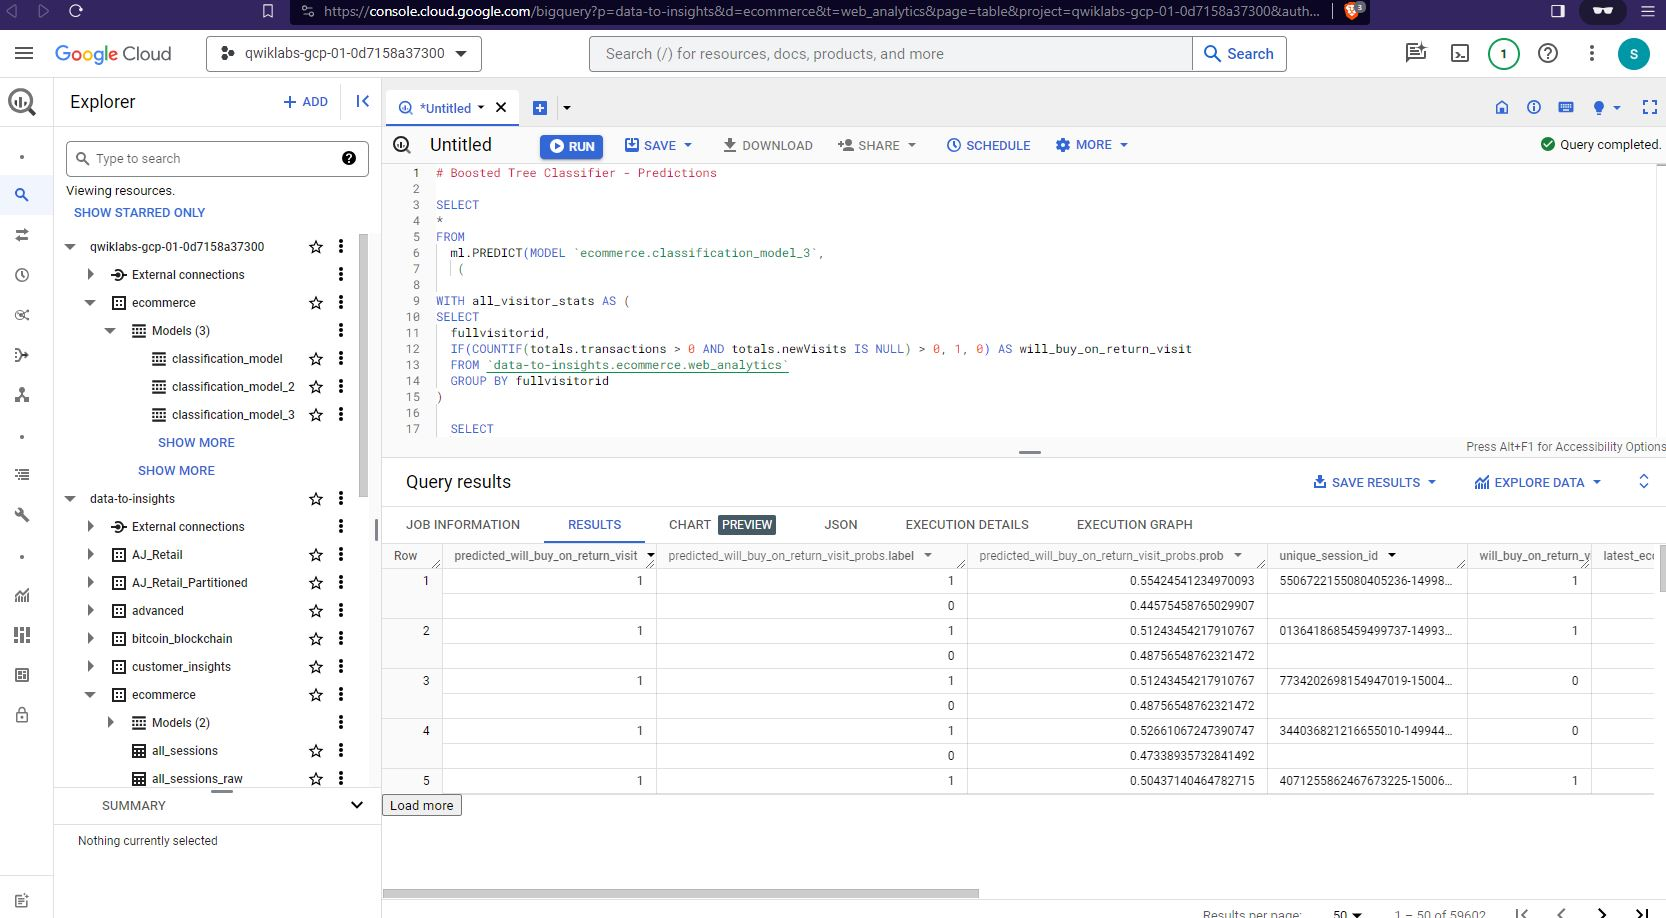


The output now shows a classification model that can better predict the probability that a first-time visitor to the Google Merchandise Store will make a purchase in a later visit. By comparing the result above with the previous model shown in Task 7, you can see the confidence the model has in its predictions is more accurate when compared to the `logistic_regression` model type.

### Key Takeaways

You created a machine learning model using just SQL.